In [190]:
pip install nltk


In [191]:
# for data
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for text preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import re

# for model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# scoring
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report

# styling
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [192]:
df = pd.read_csv('email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [194]:
df.shape

(5573, 2)

### so lets perform some basic data cleaning and preprocessing steps
### 1 remove duplicates
### 2 check for NaN values
### 3 encode the target values as they are in string format

In [195]:
df.duplicated().sum()
# quite a lot of duplicated values, best to remove them

df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [196]:
df.isnull().sum()
# thankfully no missing values

,0
Category,0
Message,0


In [197]:
df['Spam']=df['Category'].apply(lambda x:1 if x=='spam' else 0)
df.drop(columns=['Category'],inplace = True)
df.head()
# encoded the data properly into a new col

,Message,Spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### lets do some EDA on the data

Spam
0    4517
1     641
Name: count, dtype: int64


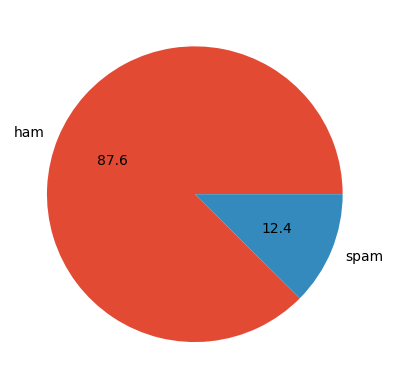

In [198]:
print(df['Spam'].value_counts())
# highly imbalanced data, keep in mind

plt.pie(df['Spam'].value_counts(),labels=['ham','spam'],autopct='%0.1f')
plt.show()

In [199]:
# as the data we have is in text format let us see if this gives us any insights.
# lets us count the number of letters, words and sentences in each row, best to make a col of each

# instead of writing lambda functions, best ot use nltk, never know what edge cases might show up

df['characters']=df['Message'].apply(len)
df.head()

df['words']=df['Message'].apply(lambda x : len(nltk.word_tokenize(x)))
df.head()

df['sentences']=df['Message'].apply(lambda x : len(nltk.sent_tokenize(x)))
df.head()

,Message,Spam,characters,words,sentences
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2
1,Ok lar... Joking wif u oni...,0,29,8,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2
3,U dun say so early hor... U c already then say...,0,49,13,1
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1


In [200]:
# analysing the new cols

df[['characters', 'words', 'sentences']].describe()

,characters,words,sentences
count,5158.000000,5158.000000,5158.000000
mean,79.091508,18.557580,1.969562
std,58.384085,13.406203,1.455448
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,118.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


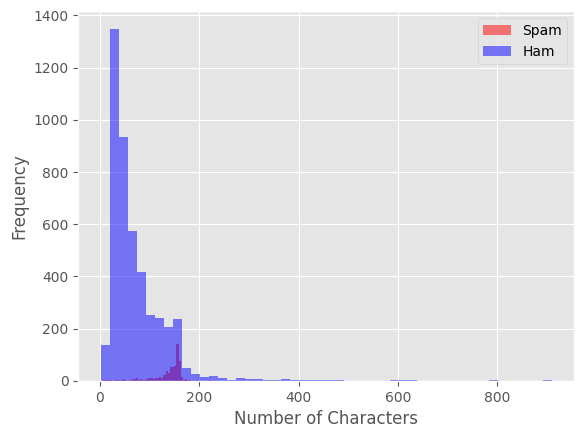

In [201]:
# lets plot a histogram for the letters in spam and ham

plt.hist(df[df['Spam'] == 1]['characters'], bins=50, alpha=0.5, color='red', label='Spam')
plt.hist(df[df['Spam'] == 0]['characters'], bins=50, alpha=0.5, color='blue', label='Ham')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# the data imbalance can again clearly be seen, the spam messages are low in number
# an interesting thing to note is that the spam messages are on average much higher that that of ham messages


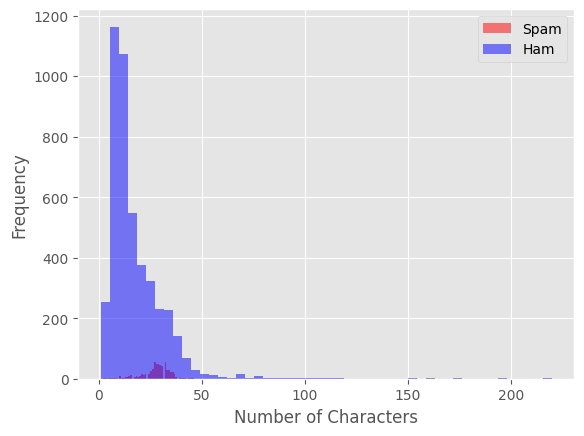

In [202]:
plt.hist(df[df['Spam'] == 1]['words'], bins=50, alpha=0.5, color='red', label='Spam')
plt.hist(df[df['Spam'] == 0]['words'], bins=50, alpha=0.5, color='blue', label='Ham')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# a similar trend in the words part of the dataset

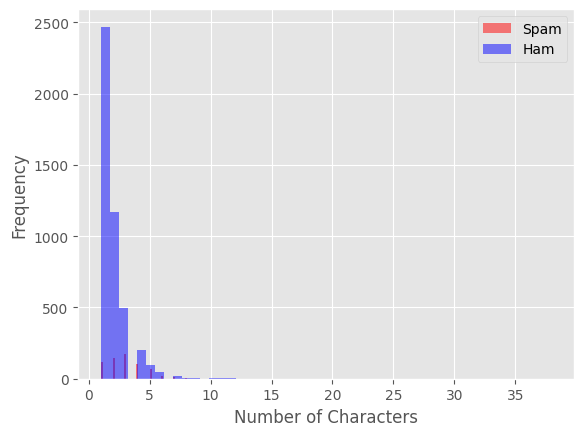

In [203]:
plt.hist(df[df['Spam'] == 1]['sentences'], bins=50, alpha=0.5, color='red', label='Spam')
plt.hist(df[df['Spam'] == 0]['sentences'], bins=50, alpha=0.5, color='blue', label='Ham')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# a similar trend in the sentences part of the dataset, maybe we can use this to our leverage

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

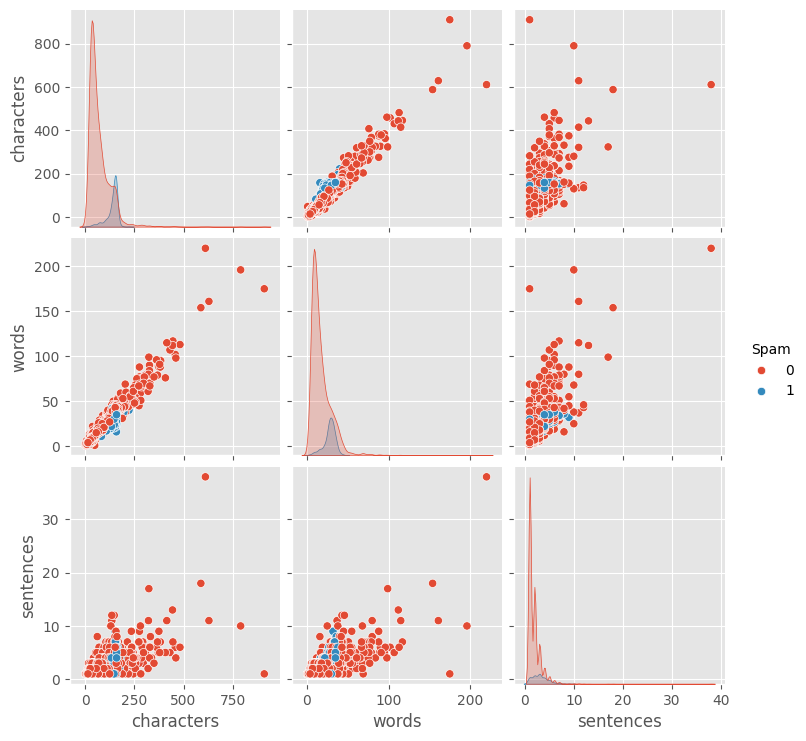

In [204]:
# to get a better idea of how the values are correleated, we can use pairplot
sns.pairplot(df, hue='Spam')

<Axes: >

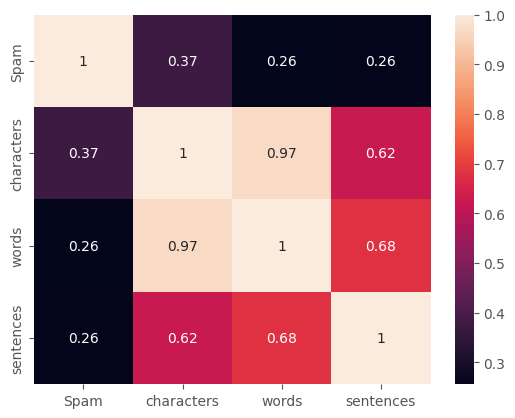

In [205]:
# to understand teh correlation better lets use a heat map
data = df.drop(columns = ['Message'])
sns.heatmap(data.corr(), annot=True)

# as seen in the plot above, the cols between words, letter and sentences are highly corelated,
# no point in taking all of them for the model training
# we can clearly see that spam has the highest corelation with letter, so we'll keep this column and discard the rest

In [206]:
### now we need to tokenize the messages,
### 1 convert to lower
### 2 remove punctuation
### 3 remove stopwords
### 4 lemmatize the words

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

df['tokens'] = df['Message'].apply(lambda x: x.lower())
df['tokens'] = df['tokens'].apply(lambda x: nltk.word_tokenize(x))
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words and word not in punctuation])
df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

df.head()

,Message,Spam,characters,words,sentences,tokens
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,"[go, jurong, point, crazy, .., available, bugi..."
1,Ok lar... Joking wif u oni...,0,29,8,2,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,0,49,13,1,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,"[nah, n't, think, go, usf, life, around, though]"


### Now starts the model building

In [214]:
cv = CountVectorizer()
X = cv.fit_transform(df['Message']).toarray()

# add the number of letter column to this
num_letters = df['characters'].values.reshape(-1, 1)
X = np.hstack((X, num_letters))
y = df['Spam'].values


# this is a good option but tf idf is somehow giving better results so we'll go with that

In [219]:
tfidf1 = TfidfVectorizer()
X = tfidf1.fit_transform(df['Message']).toarray()
y = df['Spam'].values


In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()


In [221]:
# for gaussian nb
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.8924418604651163
[[811  83]
 [ 28 110]]
0.5699481865284974


In [222]:
# for multinomial nb
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.9505813953488372
[[894   0]
 [ 51  87]]
1.0


In [223]:
# for bernoulli nb
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.9689922480620154
[[890   4]
 [ 28 110]]
0.9649122807017544


In [213]:
## as we can clearly see that the models are giving good accuracy and good precision, based on our application, we can choose to use the one we need